In [1]:
import warnings   #  免疫数据集运行及过拟合检验用的代码---随机森林！（可替换LGB，树模型不需要归一化）
warnings.filterwarnings("ignore")

In [6]:
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm,trange
import random
from lightgbm import LGBMClassifier, LGBMRegressor

%matplotlib inline

In [3]:
def scatter_loss_plot():
    plt.subplot(1,2,1)
    plt.ylim(-1,1)
    plt.xlim(-1,1)
    plt.plot(y_test[colnames[0]],y_test_pred[0],'.')

    
    plt.subplot(1,2,2)
    plt.ylim(-1,1)
    plt.xlim(-1,1)
    plt.plot(y_train[colnames[0]],y_train_pred[0],'.')

    
def rmse(obs,pre):
    return np.sqrt(mean_squared_error(obs, pre))
    
def caculate_cor():
    global r_test,r_train,y_test_pred,y_train_pred,rmse_test,rmse_train
    y_test_pred=pd.DataFrame(model.predict(x_test).reshape(y_test.shape),index=test_index)
    r_test=np.corrcoef(y_test_pred[0],y_test[colnames[0]])
    y_train_pred=pd.DataFrame(model.predict(x_train).reshape(y_train.shape),index=train_index)
    r_train=np.corrcoef(y_train_pred[0],y_train[colnames[0]])
    rmse_test=rmse(y_test[colnames[0]],y_test_pred[0])
    rmse_train=rmse(y_train[colnames[0]],y_train_pred[0])

In [4]:
xl=pd.ExcelFile('RF20210202.xlsx')
namelist=xl.sheet_names

In [5]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import KFold

rf=RandomForestRegressor(n_estimators=500,oob_score=True,random_state=0,max_features=5)
rfecv = RFECV(estimator=rf, cv=KFold(n_splits=2), scoring='r2',
              min_features_to_select=14,n_jobs=-1)
    
#for i in trange(1,13):
i=3
frame=pd.read_excel('RF20210202.xlsx',sheet_name=i) 
x_names=frame.iloc[:,0:31].columns.values.tolist()
x_data=frame.iloc[:,0:31].values
y_data=frame.iloc[:,31].values
rfecv.fit(x_data,y_data)

RFECV(cv=KFold(n_splits=2, random_state=None, shuffle=False),
      estimator=RandomForestRegressor(max_features=5, n_estimators=500,
                                      oob_score=True, random_state=0),
      min_features_to_select=14, n_jobs=-1, scoring='r2')

In [6]:
print(rfecv.n_features_)
print(rfecv.ranking_)
print(rfecv.support_)
print(rfecv.estimator_)
print(rfecv.grid_scores_)

27
[1 1 1 1 1 2 1 1 1 1 1 1 3 1 1 1 1 1 1 1 1 1 1 5 4 1 1 1 1 1 1]
[ True  True  True  True  True False  True  True  True  True  True  True
 False  True  True  True  True  True  True  True  True  True  True False
 False  True  True  True  True  True  True]
RandomForestRegressor(max_features=5, n_estimators=500, oob_score=True,
                      random_state=0)
[0.0433715  0.04625389 0.04959717 0.02938945 0.0351326  0.03664823
 0.03626452 0.03612283 0.01967203 0.02866683 0.03053086 0.04426044
 0.04094264 0.05032243 0.03823867 0.04369622 0.04062399 0.0411781 ]


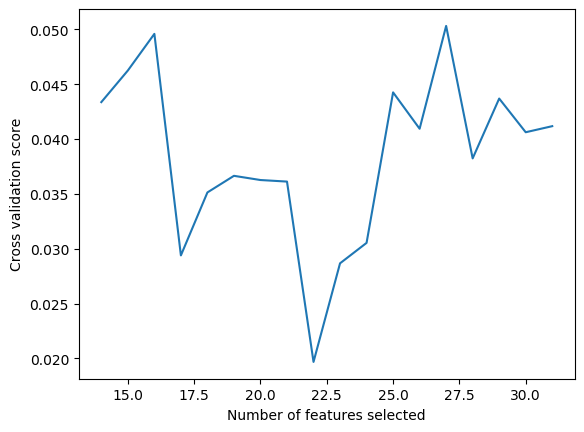

In [7]:
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score")
plt.plot(range(14, len(rfecv.grid_scores_) + 14), rfecv.grid_scores_)
plt.show()

In [8]:
globals()['colindex'+str(i)]=[]
for j in range(29):
    if rfecv.support_[j]==True:
        globals()['colindex'+str(i)].append(x_names[j])

In [17]:
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.base import clone
from itertools import combinations

In [18]:
class SBS():
    def __init__(self, estimator, k_features, scoring,
                 test_size=0.25, random_state=1):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state

    def fit(self, X, y):
        
        X_train, X_test, y_train, y_test =             train_test_split(X, y, test_size=self.test_size,
                             random_state=self.random_state)

        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train, 
                                 X_test, y_test, self.indices_)
        self.scores_ = [score]

        while dim > self.k_features:
            scores = []
            subsets = []

            for p in combinations(self.indices_, r=dim - 1):
                score = self._calc_score(X_train, y_train, 
                                         X_test, y_test, p)
                scores.append(score)
                subsets.append(p)

            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1

            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1]

        return self

    def transform(self, X):
        return X[:, self.indices_]

    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score

In [19]:
rf=RandomForestRegressor(n_estimators=500,oob_score=True,random_state=0,max_features=5)
sbs=SBS(rf,k_features=15,scoring=r2_score)
score_list=[]

#for i in trange(1,13): 可手动设置部分

    


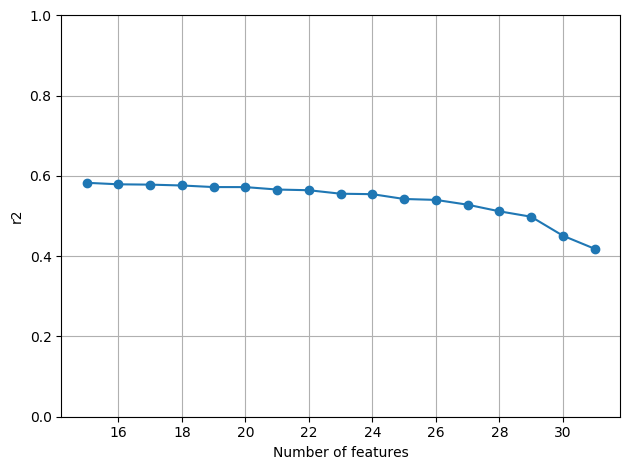

In [20]:
    i=1
    frame=pd.read_excel('RF20210202.xlsx',sheet_name=i)
    x_names=frame.iloc[:,0:31].columns.values.tolist()
    x_data=frame.iloc[:,0:31].values
    y_data=frame.iloc[:,31].values
    sbs.fit(x_data,y_data)
    
    k_feat = [len(k) for k in sbs.subsets_]
    score_list.append(sbs.scores_)
    
    plt.plot(k_feat, sbs.scores_, marker='o')
    plt.ylim([0, 1])
    plt.ylabel('r2')
    plt.xlabel('Number of features')
    plt.grid()
    plt.tight_layout()
    # plt.savefig('images/04_08.png', dpi=300)
    plt.show()
    
    k=sbs.scores_.index(max(sbs.scores_))
    globals()['k'+str(i)]=list(sbs.subsets_[k])

    globals()['colindex'+str(i)]=[]
    for j in globals()['k'+str(i)]:
        globals()['colindex'+str(i)].append(x_names[j])
    #feature_remian=frame.columns[1:][globals()['k'+str(29-k)]]
    #print(feature_remian)

In [21]:
score_df=pd.DataFrame(score_list)
score_df=score_df.stack().unstack(0)
xl=pd.ExcelFile('RF20210202.xlsx')

score_df.to_excel('sbs-score.xlsx',sheet_name='sheet1')

# rf-regression

In [4]:
import joblib
#xl = pd.ExcelFile('RF20210202.xlsx')
xl = pd.ExcelFile('RF20230520.xlsx')
namelist=xl.sheet_names[1:13]
#predf=pd.read_excel('experiment materials.xlsx',sheet_name=1).iloc[0:5,0:31]

writer1=pd.ExcelWriter('all-lgb-op.xlsx')
writer2=pd.ExcelWriter('all-lgb-cor.xlsx')
writer3=pd.ExcelWriter('all-lgb-imp.xlsx')
writer4=pd.ExcelWriter('all-lgb-pre.xlsx')
writer5=pd.ExcelWriter('all-lgb-val.xlsx')

In [7]:
for i in trange(1,13):
    #frame=pd.read_excel('RF20210202.xlsx',sheet_name=i)
    frame=pd.read_excel('RF20230520.xlsx',sheet_name=i)
    
    if i<12:
        random.seed(3)
    else:
        random.seed(2)
    
    val=random.sample(range(0,len(frame)),5)           #随机抽取所有数据中的5个样本
    model_index=list(frame.index)

    for j in val:
        model_index.remove(j)
    valdata=frame.loc[val,:]
    val_x=valdata.iloc[:,0:31]
    val_y=valdata.iloc[:,31:]
    frame=frame.loc[model_index,:]
    x_data=frame.iloc[:,0:31]
    #x_data=frame[globals()['colindex'+str(i)]]
    x_data.index=range(len(x_data))
    y_data=frame.iloc[:,31:]
    y_data.index=range(len(y_data))
    x_names=x_data.columns.values.tolist()
    colnames=y_data.columns.values.tolist()
    
    ss=ShuffleSplit(n_splits=10, test_size=0.1,random_state=0)
    
    
    #stdsc=StandardScaler()
    prelist=[]
    vallist=[]
    corlist_train=[]
    corlist_test=[]
    rmsel_train=[]
    rmsel_test=[]
    o=[]
    imp=[]
    

    #model=RandomForestRegressor(n_estimators=500,oob_score=True,random_state=0,max_features=5)  #,min_samples_leaf=2)
    model=LGBMRegressor(learning_rate=0.31, max_depth=10,random_state=0)
    
    
    
    #with tqdm(total=10) as pbar:
    for train_index , test_index in ss.split(x_data,y_data):
        x_train=x_data.iloc[train_index,:]
        x_train.columns=x_names
        
        y_train=y_data.iloc[train_index,:]
        
        x_test=x_data.iloc[test_index,:]
        x_test.columns=x_names
    
        y_test=y_data.iloc[test_index,:]
        
        model.fit(x_train,np.array(y_train).ravel())       #模型拟合
        
        
        #joblib.dump(model, f'D:/策划类/01NKU/机器学习中的因果推断/因果机器学习/12第12次组会文献/代码运行数据保存/RF-new-data/R-model-{i}.pkl')
        
        val_one=model.predict(val_x)
        
        vallist.append(val_one.T)
        #pre_one=model.predict(predf)
        #prelist.append(pre_one.T)
        caculate_cor()
        corlist_train.append(r_train[1,0])
        corlist_test.append(r_test[1,0])
        rmsel_train.append(rmse_train)
        rmsel_test.append(rmse_test)
       # scatter_loss_plot()
        o.append(y_train[colnames[0]])
        o.append(y_train_pred[0])
        o.append(y_test[colnames[0]])
        o.append(y_test_pred[0])
        #pbar.update()           
        imp.append(model.feature_importances_)

    #plt.show()        
    cordf=pd.DataFrame({'train':corlist_train,'test':corlist_test,
                        'rmse_train':rmsel_train,'rmse_test':rmsel_test})
    obs_pre_df=pd.DataFrame([y_data[colnames[0]],o[1],o[5],o[9],o[13],o[17],o[21],o[25],o[29],o[33],o[37],
                            o[3],o[7],o[11],o[15],o[19],o[23],o[27],o[31],o[35],o[39]]).T
    obs_pre_df.columns=(colnames[0],'train1','train2','train3','train4','train5',
                        'train6','train7','train8','train9','train10',
                        'test1','test2','test3','test4','test5',
                        'test6','test7','test8','test9','test10')
    presult=pd.DataFrame(prelist,columns=['T','C','S','M','L']).T
    vresult=pd.DataFrame(vallist,columns=val).T
    
    print(np.corrcoef(np.array(np.mean(vresult.T)).ravel(),
                          np.array(val_y).ravel())[0,1])             #相关性R2
    vresult['predict']=np.array(np.mean(vresult.T)).ravel()
    vresult['observe']=val_y
    vresult['error']=vresult['predict']-vresult['observe']

    #imp_df=pd.DataFrame(imp,columns=globals()['colindex'+str(i)])
    imp_df=pd.DataFrame(imp,columns=x_names)
    obs_pre_df.to_excel(writer1,sheet_name=colnames[0])
    cordf.to_excel(writer2,sheet_name=colnames[0])
    imp_df.to_excel(writer3,sheet_name=colnames[0])
    presult.to_excel(writer4,sheet_name=colnames[0])
    vresult.to_excel(writer5,sheet_name=colnames[0])
    
writer1.save()
writer2.save()
writer3.save()
writer4.save()
writer5.save()




  8%|██████▉                                                                            | 1/12 [00:01<00:12,  1.18s/it]

0.9828448185719523


 17%|█████████████▊                                                                     | 2/12 [00:02<00:11,  1.16s/it]

0.8729786539131414


 25%|████████████████████▊                                                              | 3/12 [00:03<00:11,  1.24s/it]

0.8598510005046514


 33%|███████████████████████████▋                                                       | 4/12 [00:04<00:09,  1.23s/it]

-0.21170759335922248
0.013777763087573641


 50%|█████████████████████████████████████████▌                                         | 6/12 [00:07<00:07,  1.17s/it]

0.8671332845598945


 58%|████████████████████████████████████████████████▍                                  | 7/12 [00:08<00:05,  1.04s/it]

0.9574784770791128


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [00:08<00:03,  1.05it/s]

0.9634068474665124


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [00:09<00:02,  1.27it/s]

0.9248778261742461


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [00:09<00:01,  1.47it/s]

0.8076204427964809


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [00:10<00:00,  1.55it/s]

0.24324821973777377


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:10<00:00,  1.11it/s]

0.8783310771692358


# IL-1B  验证结果

In [7]:
i=6
frame=pd.read_excel('RF20210202.xlsx',sheet_name=i)
random.seed(3)

val=random.sample(range(0,len(frame)),5)
model_index=list(frame.index)
for j in val:
    model_index.remove(j)
valdata=frame.loc[val,:]
val_x=valdata.iloc[:,0:31]
val_y=valdata.iloc[:,31:]
frame=frame.loc[model_index,:]
x_data=frame.iloc[:,0:31]
#x_data=frame[globals()['colindex'+str(i)]]
x_data.index=range(len(x_data))
y_data=frame.iloc[:,31:]
y_data.index=range(len(y_data))
x_names=x_data.columns.values.tolist()
colnames=y_data.columns.values.tolist()

ss=ShuffleSplit(n_splits=10, test_size=0.1,random_state=0)
predf=pd.read_excel('experiment materials.xlsx',sheet_name=1).iloc[5:11,0:31]
model=RandomForestRegressor(n_estimators=500,oob_score=True,random_state=0,
                            max_features=5#,min_samples_leaf=2
                            )
pre2list=[]
with tqdm(total=10) as pbar:
    for train_index , test_index in ss.split(x_data,y_data):
        x_train=x_data.iloc[train_index,:]
        x_train.columns=x_names      
        y_train=y_data.iloc[train_index,:]       
        x_test=x_data.iloc[test_index,:]
        x_test.columns=x_names
        y_test=y_data.iloc[test_index,:]       
        model.fit(x_train,y_train)
        pre=model.predict(predf)  
        pre2list.append(pre)
p2result=pd.DataFrame(pre2list).T
p2result.to_excel('il1b.xlsx')

  0%|                                                                                           | 0/10 [00:06<?, ?it/s]


# permutation test

In [4]:
xl = pd.ExcelFile('RF20230520.xlsx')
namelist=xl.sheet_names[1:13]
model=RandomForestRegressor(n_estimators=500,oob_score=True,random_state=0,
                                max_features=5#,min_samples_leaf=2
                                )
writer1=pd.ExcelWriter('permutation.xlsx')

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

 20%|████████████████▊                                                                   | 1/5 [00:08<00:33,  8.26s/it]

 40%|█████████████████████████████████▌                                                  | 2/5 [00:16<00:24,  8.32s/it]

 60%|██████████████████████████████████████████████████▍                                 | 3/5 [00:25<00:16,  8.41s/it]

 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [00:33<00:08,  8.48s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:42<00:00,  8.49s/it]

 10%|████████▎                                                                          | 1/10 [00:43<06:29, 43.25s/it]

  0%|                           

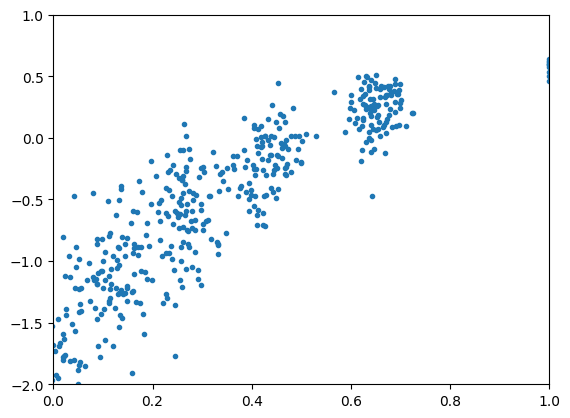

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

 20%|████████████████▊                                                                   | 1/5 [00:08<00:34,  8.54s/it]

 40%|█████████████████████████████████▌                                                  | 2/5 [00:18<00:28,  9.54s/it]

 60%|██████████████████████████████████████████████████▍                                 | 3/5 [00:28<00:18,  9.44s/it]

 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [00:37<00:09,  9.42s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:46<00:00,  9.37s/it]

 10%|████████▎                                                                          | 1/10 [00:47<07:09, 47.70s/it]

  0%|                           

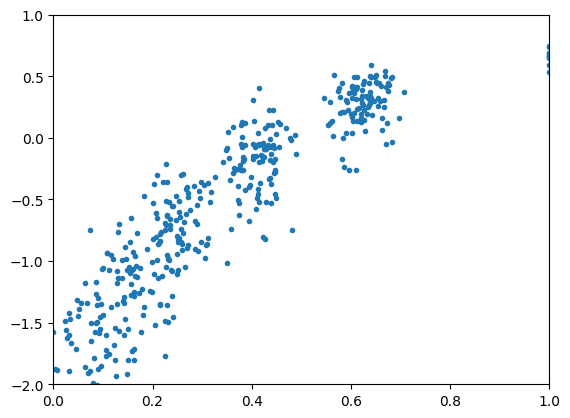

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

 20%|████████████████▊                                                                   | 1/5 [00:09<00:37,  9.46s/it]

 40%|█████████████████████████████████▌                                                  | 2/5 [00:18<00:28,  9.39s/it]

 60%|██████████████████████████████████████████████████▍                                 | 3/5 [00:28<00:19,  9.51s/it]

 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [00:38<00:09,  9.58s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:47<00:00,  9.59s/it]

 10%|████████▎                                                                          | 1/10 [00:48<07:19, 48.87s/it]

  0%|                           

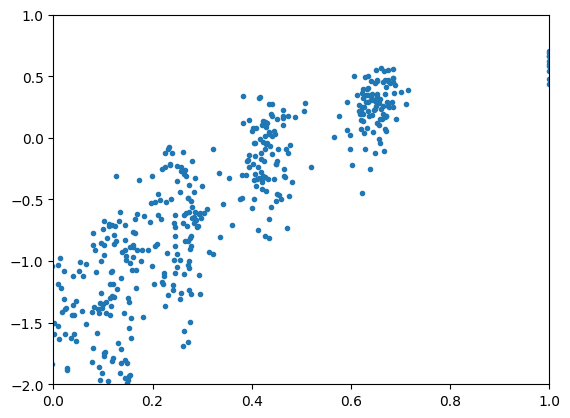

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

 20%|████████████████▊                                                                   | 1/5 [00:08<00:35,  8.83s/it]

 40%|█████████████████████████████████▌                                                  | 2/5 [00:17<00:26,  8.90s/it]

 60%|██████████████████████████████████████████████████▍                                 | 3/5 [00:26<00:17,  8.95s/it]

 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [00:36<00:09,  9.09s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:45<00:00,  9.10s/it]

 10%|████████▎                                                                          | 1/10 [00:46<06:57, 46.35s/it]

  0%|                           

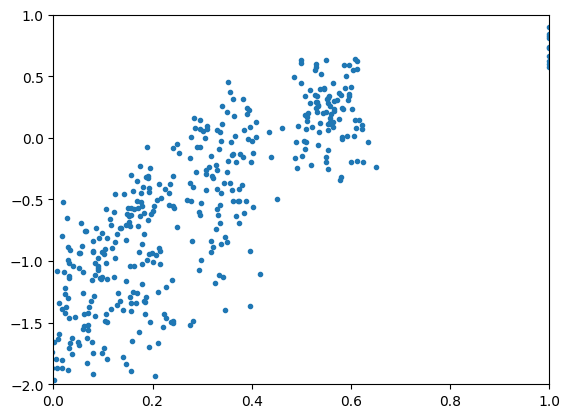

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

 20%|████████████████▊                                                                   | 1/5 [00:11<00:47, 11.91s/it]

 40%|█████████████████████████████████▌                                                  | 2/5 [00:24<00:36, 12.15s/it]

 60%|██████████████████████████████████████████████████▍                                 | 3/5 [00:38<00:26, 13.10s/it]

 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [00:51<00:13, 13.22s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:05<00:00, 13.12s/it]

 10%|████████▎                                                                          | 1/10 [01:06<10:01, 66.84s/it]

  0%|                           

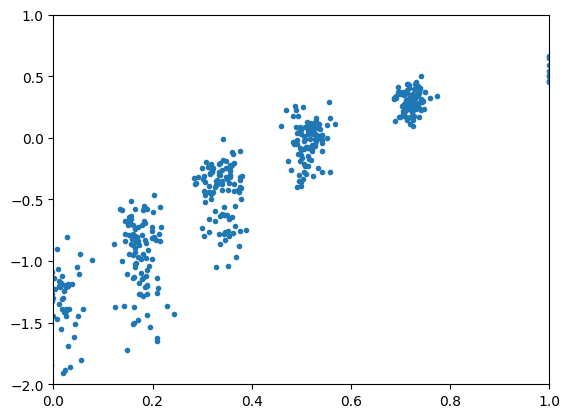

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

 20%|████████████████▊                                                                   | 1/5 [00:08<00:32,  8.04s/it]

 40%|█████████████████████████████████▌                                                  | 2/5 [00:14<00:21,  7.28s/it]

 60%|██████████████████████████████████████████████████▍                                 | 3/5 [00:21<00:14,  7.03s/it]

 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [00:28<00:06,  6.96s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:35<00:00,  7.09s/it]

 10%|████████▎                                                                          | 1/10 [00:36<05:25, 36.11s/it]

  0%|                           

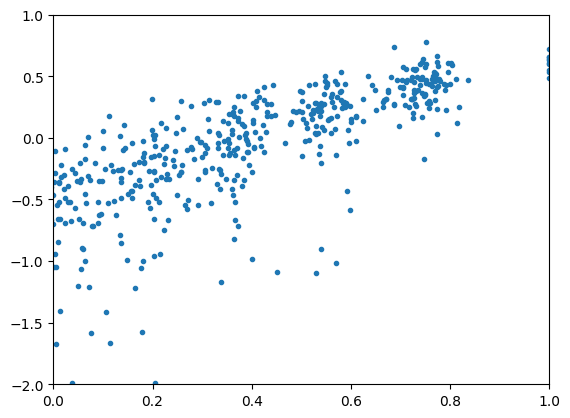

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

 20%|████████████████▊                                                                   | 1/5 [00:06<00:27,  6.87s/it]

 40%|█████████████████████████████████▌                                                  | 2/5 [00:14<00:21,  7.14s/it]

 60%|██████████████████████████████████████████████████▍                                 | 3/5 [00:21<00:14,  7.13s/it]

 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [00:28<00:07,  7.14s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:35<00:00,  7.11s/it]

 10%|████████▎                                                                          | 1/10 [00:36<05:26, 36.24s/it]

  0%|                           

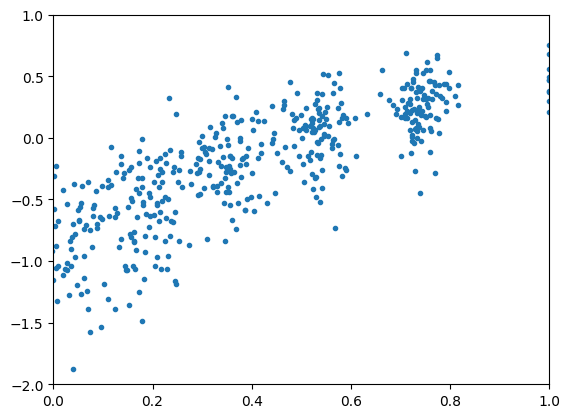

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

 20%|████████████████▊                                                                   | 1/5 [00:06<00:27,  6.81s/it]

 40%|█████████████████████████████████▌                                                  | 2/5 [00:13<00:20,  6.81s/it]

 60%|██████████████████████████████████████████████████▍                                 | 3/5 [00:20<00:13,  6.79s/it]

 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [00:27<00:06,  6.88s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:34<00:00,  6.86s/it]

 10%|████████▎                                                                          | 1/10 [00:34<05:14, 34.99s/it]

  0%|                           

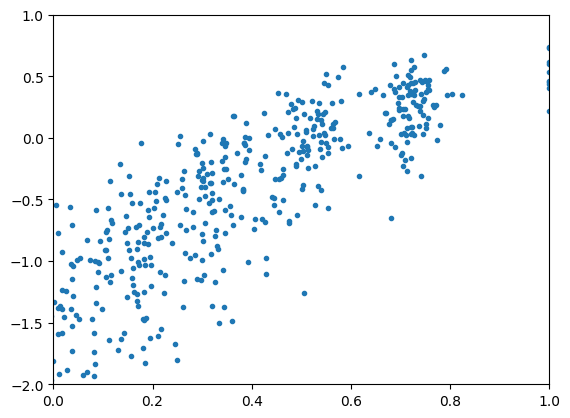

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

 20%|████████████████▊                                                                   | 1/5 [00:05<00:21,  5.46s/it]

 40%|█████████████████████████████████▌                                                  | 2/5 [00:11<00:16,  5.51s/it]

 60%|██████████████████████████████████████████████████▍                                 | 3/5 [00:16<00:11,  5.62s/it]

 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [00:22<00:05,  5.63s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:27<00:00,  5.60s/it]

 10%|████████▎                                                                          | 1/10 [00:28<04:16, 28.52s/it]

  0%|                           

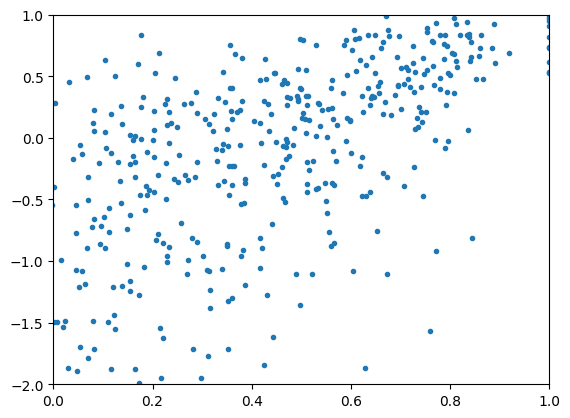

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

 20%|████████████████▊                                                                   | 1/5 [00:05<00:21,  5.42s/it]

 40%|█████████████████████████████████▌                                                  | 2/5 [00:10<00:16,  5.49s/it]

 60%|██████████████████████████████████████████████████▍                                 | 3/5 [00:16<00:11,  5.50s/it]

 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [00:21<00:05,  5.48s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:27<00:00,  5.50s/it]

 10%|████████▎                                                                          | 1/10 [00:28<04:12, 28.03s/it]

  0%|                           

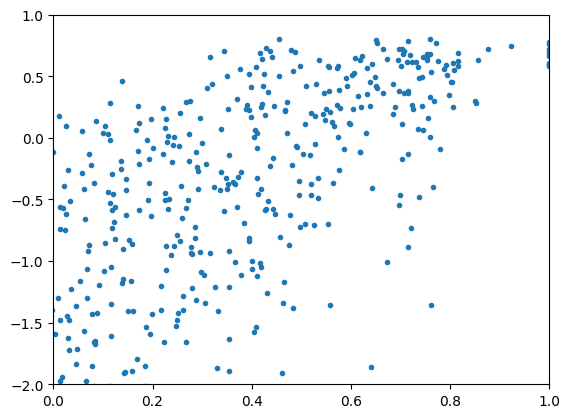

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

 20%|████████████████▊                                                                   | 1/5 [00:05<00:22,  5.72s/it]

 40%|█████████████████████████████████▌                                                  | 2/5 [00:11<00:17,  5.68s/it]

 60%|██████████████████████████████████████████████████▍                                 | 3/5 [00:17<00:11,  5.79s/it]

 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [00:23<00:05,  5.89s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:29<00:00,  5.87s/it]

 10%|████████▎                                                                          | 1/10 [00:29<04:29, 29.92s/it]

  0%|                           

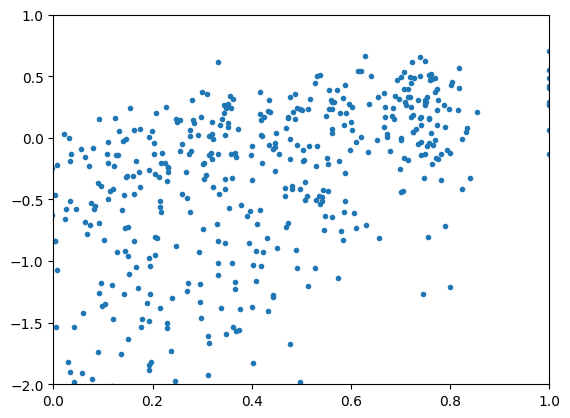

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

 20%|████████████████▊                                                                   | 1/5 [00:05<00:21,  5.42s/it]

 40%|█████████████████████████████████▌                                                  | 2/5 [00:10<00:16,  5.36s/it]

 60%|██████████████████████████████████████████████████▍                                 | 3/5 [00:16<00:10,  5.43s/it]

 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [00:21<00:05,  5.50s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:27<00:00,  5.49s/it]

 10%|████████▎                                                                          | 1/10 [00:27<04:11, 27.99s/it]

  0%|                           

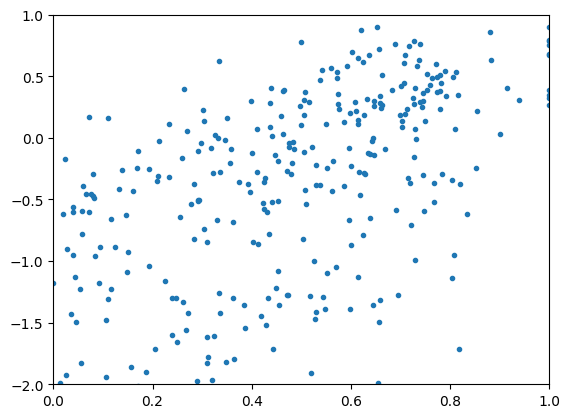

100%|███████████████████████████████████████████████████████████████████████████████| 12/12 [1:19:24<00:00, 397.06s/it]


In [5]:
for i in trange(1,13):
    frame=pd.read_excel('RF20230520.xlsx',sheet_name=i)
    random.seed(i)
    val=random.sample(range(0,len(frame)),5)
    model_index=list(frame.index)
    for j in val:
        model_index.remove(j)
    #x_data=frame[globals()['colindex'+str(i)]]
    valdata=frame.iloc[val,:]
    val_x=valdata.iloc[:,0:31]
    val_y=valdata.iloc[:,31:]
    frame=frame.iloc[model_index,:]
    x_data=frame.iloc[:,0:31]
    x_data.index=range(len(x_data))
    y_data=frame.iloc[:,31:]
    y_data.index=range(len(y_data))
    x_names=x_data.columns.values.tolist()
    colnames=y_data.columns.values.tolist()
    
    ss=ShuffleSplit(n_splits=10, test_size=0.1,random_state=0)
    #stdsc=StandardScaler()
    r2_list=[]
    q2_list=[]
    model=RandomForestRegressor(n_estimators=500,oob_score=True,random_state=0,
                                max_features=5#,min_samples_leaf=2
                                )
    with tqdm(total=10) as pbar:
        for train_index , test_index in ss.split(x_data,y_data):
            x_train=x_data.iloc[train_index,:]
            x_train.columns=x_names
            y_train=y_data.iloc[train_index,:]
            x_test=x_data.loc[test_index,:]
            x_test.columns=x_names        
            y_test=y_data.loc[test_index,:]
            
            for j in trange(5):
                for k in range(10):
                    random.seed(i+j+k)
                    per_index=np.random.choice(train_index,round((j+1)*0.2*len(x_train)),False)
                    y_train_per=y_train.copy()
                    for i_index in per_index:
                        y_train_per.loc[i_index,:]=np.random.uniform(-1,1)
                    model.fit(x_train,np.array(y_train_per).ravel())
                    r2_list.append(
                        np.corrcoef(y_train.iloc[:,0],y_train_per.iloc[:,0])[0,1])
                    y_array=np.array(y_test).ravel()
                    rss=np.sum((y_array-model.predict(x_test))**2)                          
                    tss=np.sum((y_array-np.mean(y_array))**2)
                    q2=1-rss/tss
                    q2_list.append(q2)
                
            model.fit(x_train,np.array(y_train).ravel())
            r2_list.append(1)
            rss=np.sum((y_array-model.predict(x_test))**2)                          
            tss=np.sum((y_array-np.mean(y_array))**2)
            q2=1-rss/tss
            q2_list.append(q2)
            pbar.update() 
             
    perdf=pd.DataFrame({'r2':r2_list,'q2':q2_list})
    
    plt.ylim(-2,1)
    plt.xlim(0,1)
    plt.plot(perdf['r2'],perdf['q2'],'.')
    plt.show()
    perdf.to_excel(writer1,sheet_name=colnames[0])
writer1.save()